Reading existing data.csv file...
Processing prediction file: paste.txt
Example conversion for index 259:
Original value: 2.608533e+07
Converted value (× 8 ÷ 1,000,000): 203.863200 Mbps
Data saved to network_data_with_predictions.csv
Creating visualization...
Multi-panel visualization saved successfully as network_traffic_with_predictions.png!


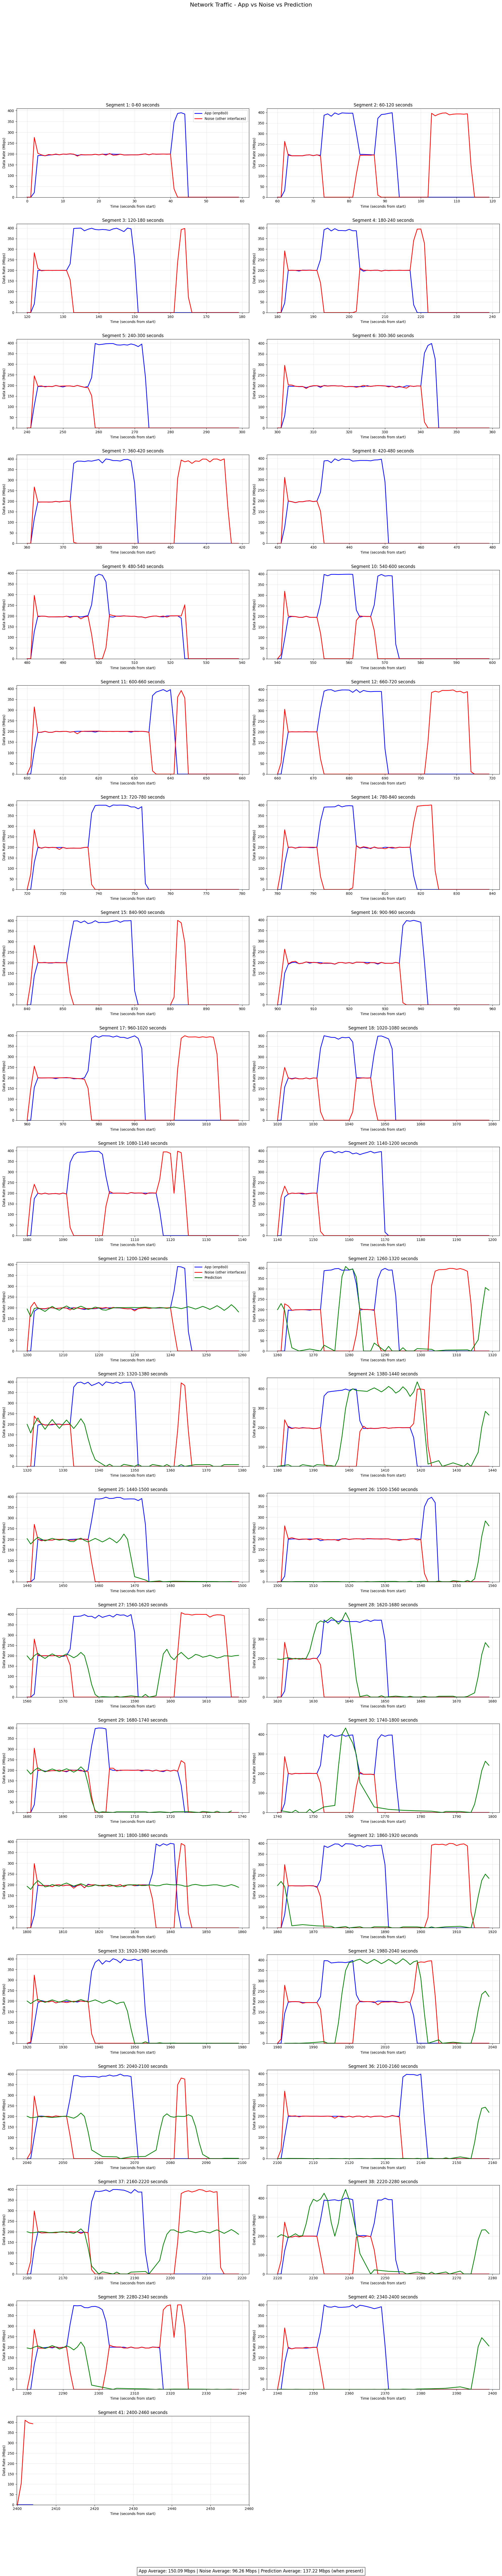

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
from datetime import datetime, timedelta

# Function to process the prediction values file
def process_prediction_file(filename='paste.txt'):
    print(f"Processing prediction file: {filename}")
    with open(filename, 'r') as file:
        lines = file.readlines()

    # Process the prediction values
    prediction_data = []
    for line in lines[2:]:  # Skip the header lines
        if '----------------------------------------' in line:
            continue

        parts = line.strip().split('\t')
        if len(parts) == 2:
            index = int(parts[0])
            try:
                prediction_value = float(parts[1])
                # Multiply by 8 and divide by a million
                mbps_value = (prediction_value * 8) / 1000000
                prediction_data.append((index, mbps_value))
            except ValueError:
                # Skip lines that don't contain valid floats
                continue

    return prediction_data

# Function to add predictions to an existing dataset
def add_predictions_to_dataset(df, prediction_data, prediction_start_time=1200):
    # Create a copy of the dataframe
    new_df = df.copy()

    # Add a prediction column if it doesn't exist
    if 'prediction_mbps' not in new_df.columns:
        new_df['prediction_mbps'] = 0.0

    # Calculate total noise traffic if not present
    if 'total_noise_mbps' not in new_df.columns:
        new_df['total_noise_mbps'] = new_df['enp10s0_mbps'] + new_df['enp11s0_mbps'] + new_df['enp7s0_mbps']

    # Add prediction values to the dataframe
    for idx, value in prediction_data:
        # Prediction time is original index + start time
        prediction_time = idx + prediction_start_time

        # Find the closest timestamp in our dataframe
        closest_idx = (new_df['seconds'] - prediction_time).abs().idxmin()

        # Update the prediction value
        new_df.at[closest_idx, 'prediction_mbps'] = value

    return new_df

# Function to visualize the data
def visualize_data(df, output_filename="network_traffic_with_predictions.png"):
    print("Creating visualization...")

    # Convert timestamp to datetime for better plotting
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])

    # Calculate total noise if not already calculated
    if 'total_noise_mbps' not in df.columns:
        df['total_noise_mbps'] = df['enp10s0_mbps'] + df['enp11s0_mbps'] + df['enp7s0_mbps']

    # Extract app traffic and noise
    app_traffic = df['enp8s0_mbps']
    noise_traffic = df['total_noise_mbps']

    # Calculate averages
    app_avg = app_traffic.mean()
    noise_avg = noise_traffic.mean()

    # Calculate prediction average (only for non-zero values)
    pred_data = df.loc[df['prediction_mbps'] > 0, 'prediction_mbps']
    pred_avg = pred_data.mean() if not pred_data.empty else 0

    # Determine number of segments to create based on data size
    total_seconds = df['seconds'].max()
    segment_length = 60  # 60 seconds per panel as in your original code
    num_segments = math.ceil(total_seconds / segment_length)

    # Create a multi-panel figure
    num_rows = math.ceil(num_segments / 2)  # 2 panels per row
    fig, axes = plt.subplots(num_rows, 2, figsize=(20, 5 * num_rows))

    if num_rows == 1 and num_segments == 1:
        axes = np.array([axes])  # Make it into an array for consistency
    axes = axes.flatten()  # Flatten the axes array for easier indexing

    # Loop through each segment and plot the data
    for i in range(num_segments):
        start_time = i * segment_length
        end_time = (i + 1) * segment_length

        # Filter data for current segment
        segment_data = df[(df['seconds'] >= start_time) & (df['seconds'] < end_time)]

        if len(segment_data) > 0:
            # Plot App traffic
            axes[i].plot(segment_data['seconds'], segment_data['enp8s0_mbps'],
                      'b-', linewidth=2, label='App (enp8s0)')

            # Plot Noise traffic (sum of all noise interfaces)
            axes[i].plot(segment_data['seconds'],
                      segment_data['enp10s0_mbps'] + segment_data['enp11s0_mbps'] + segment_data['enp7s0_mbps'],
                      'r-', linewidth=2, label='Noise (other interfaces)')

            # Plot Prediction traffic (only where it exists)
            prediction_data = segment_data[segment_data['prediction_mbps'] > 0]
            if len(prediction_data) > 0:
                axes[i].plot(prediction_data['seconds'], prediction_data['prediction_mbps'],
                          'g-', linewidth=2, label='Prediction')

            # Add segment title and labels
            axes[i].set_title(f'Segment {i+1}: {start_time}-{end_time} seconds')
            axes[i].set_xlabel('Time (seconds from start)')
            axes[i].set_ylabel('Data Rate (Mbps)')
            axes[i].grid(True, alpha=0.3)
            axes[i].set_ylim(bottom=0)

            # Add more tick marks for better readability
            axes[i].set_xticks(np.arange(start_time, end_time + 1, 10))

            # Show legend on first panel and first panel with predictions
            if i == 0 or (segment_data['prediction_mbps'].max() > 0 and
                         all(df.loc[:segment_data.index.min()-1, 'prediction_mbps'] == 0)):
                axes[i].legend(loc='upper right')

    # Remove any unused subplot panels
    for i in range(num_segments, len(axes)):
        fig.delaxes(axes[i])

    # Add global averages annotation
    avg_text = f'App Average: {app_avg:.2f} Mbps | Noise Average: {noise_avg:.2f} Mbps'
    if pred_avg > 0:
        avg_text += f' | Prediction Average: {pred_avg:.2f} Mbps (when present)'

    plt.figtext(0.5, 0.01, avg_text,
               ha='center', fontsize=12, bbox={'facecolor':'white', 'alpha':0.8, 'pad':5})

    # Adjust layout
    plt.tight_layout(rect=[0, 0.03, 1, 0.97])
    plt.subplots_adjust(top=0.94, hspace=0.3)

    # Add overall title
    plt.suptitle('Network Traffic - App vs Noise vs Prediction', fontsize=16)

    # Save the visualization
    plt.savefig(output_filename, dpi=300, bbox_inches='tight')

    print(f"Multi-panel visualization saved successfully as {output_filename}!")
    return

# Main execution
if __name__ == "__main__":
    # Read your existing data.csv file
    try:
        # Try to read existing data file
        print("Reading existing data.csv file...")
        df = pd.read_csv('data.csv')

        # Convert timestamp to datetime
        df['Timestamp'] = pd.to_datetime(df['Timestamp'])

        # Ensure necessary columns exist
        required_cols = ['enp8s0_mbps', 'enp10s0_mbps', 'enp11s0_mbps', 'enp7s0_mbps']
        for col in required_cols:
            if col not in df.columns:
                # If the column name doesn't end with _mbps, check if it exists without the suffix
                base_col = col.replace('_mbps', '')
                if base_col in df.columns:
                    # Rename the column
                    df[col] = df[base_col]
                else:
                    print(f"Warning: Column {col} not found in data.csv. Creating empty column.")
                    df[col] = 0.0

        # Ensure we have a seconds column
        if 'seconds' not in df.columns:
            df['seconds'] = (df['Timestamp'] - df['Timestamp'].iloc[0]).dt.total_seconds()

    except FileNotFoundError:
        # If no data.csv exists, create a simple example dataframe
        print("No data.csv found. Creating sample data...")

        # Create timestamps at 1-second intervals
        num_samples = 2000  # 2000 seconds of data
        current_time = datetime.now()
        timestamps = [current_time + timedelta(seconds=i) for i in range(num_samples)]

        # Generate sample data
        import numpy as np
        seconds = np.arange(num_samples)
        enp8s0 = np.random.uniform(50, 150, num_samples)  # App traffic
        enp10s0 = np.random.uniform(10, 30, num_samples)  # Noise 1
        enp11s0 = np.random.uniform(5, 15, num_samples)   # Noise 2
        enp7s0 = np.random.uniform(20, 40, num_samples)   # Noise 3

        # Create dataframe
        df = pd.DataFrame({
            'Timestamp': timestamps,
            'seconds': seconds,
            'enp8s0_mbps': enp8s0,
            'enp10s0_mbps': enp10s0,
            'enp11s0_mbps': enp11s0,
            'enp7s0_mbps': enp7s0
        })

    # Process the prediction values
    prediction_data = process_prediction_file('paste.txt')

    # Example of a converted value (2.608533e+07 at index 259)
    for idx, value in prediction_data:
        if idx == 259:
            print(f"Example conversion for index 259:")
            print(f"Original value: 2.608533e+07")
            print(f"Converted value (× 8 ÷ 1,000,000): {value:.6f} Mbps")
            break

    # Add predictions to the dataset starting at second 1200
    df_with_predictions = add_predictions_to_dataset(df, prediction_data, prediction_start_time=1200)

    # Save to CSV
    df_with_predictions.to_csv('network_data_with_predictions.csv', index=False)
    print("Data saved to network_data_with_predictions.csv")

    # Create the visualization
    visualize_data(df_with_predictions)

Multi-panel visualization saved successfully!


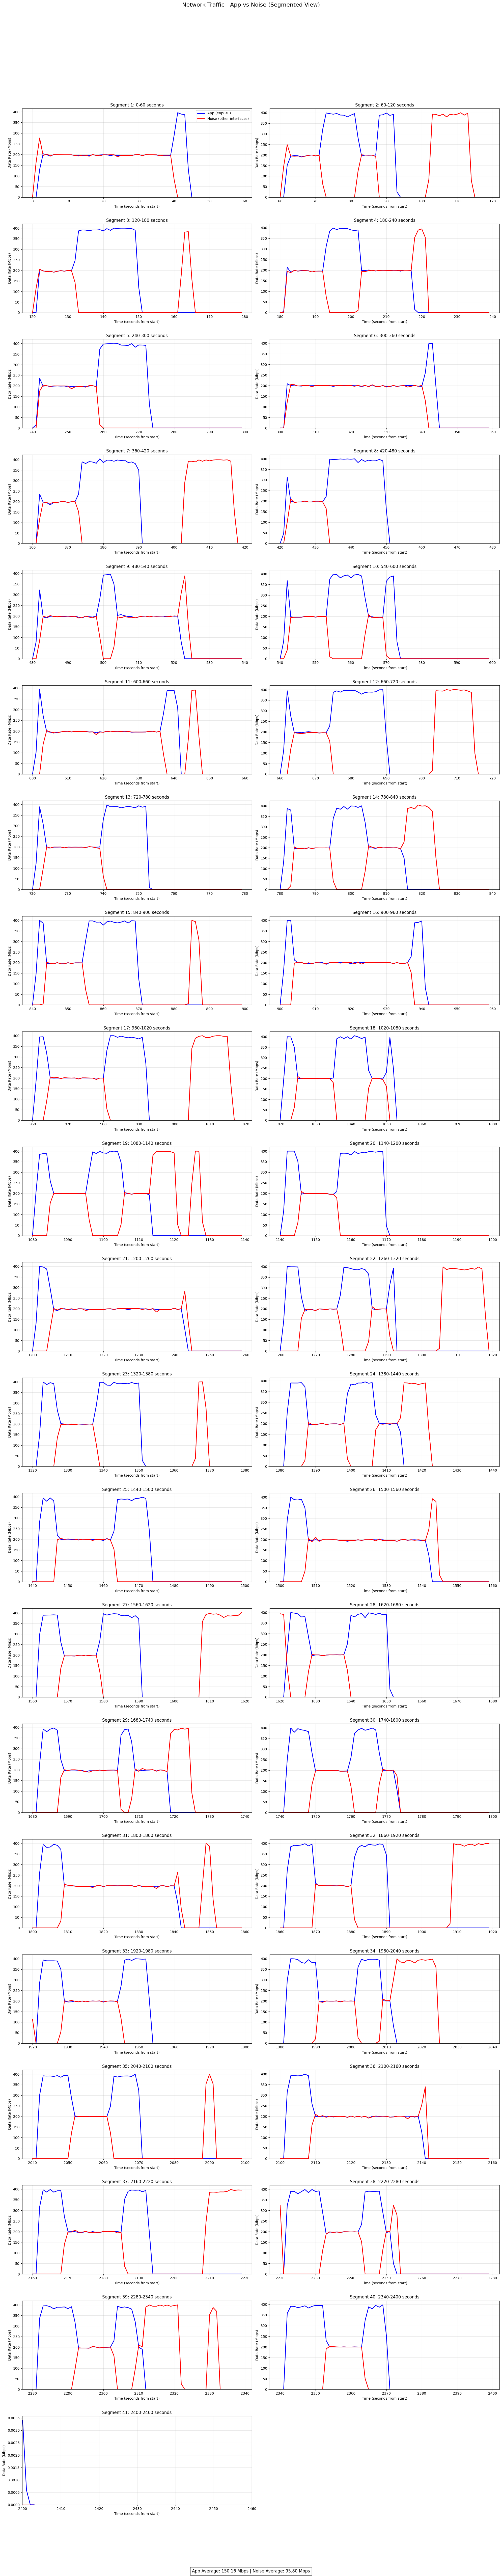

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math

# Read the data file
df = pd.read_csv('data.csv')

# Convert timestamp to datetime for better plotting
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# Remove duplicate Timestamps (if any)
df = df.drop_duplicates(subset=['Timestamp'])

# Replace any empty strings or NaN with 0 and convert to float for all interfaces
for col in ['enp10s0', 'enp11s0', 'enp7s0', 'enp8s0']:
    if col in df.columns:
        df[col] = df[col].replace('', 0).fillna(0).astype(float)

# Calculate seconds from first timestamp for x-axis
df['seconds'] = (df['Timestamp'] - df['Timestamp'].iloc[0]).dt.total_seconds()

# Extract app traffic (enp8s0)
app_traffic = df['enp8s0_mbps']

# Calculate noise (sum of all other interfaces)
noise_traffic = df['enp10s0_mbps'] + df['enp11s0_mbps'] + df['enp7s0_mbps']

# Calculate averages
app_avg = app_traffic.mean()
noise_avg = noise_traffic.mean()

# Determine number of segments to create based on data size
# Each segment will show a portion of the data
total_seconds = df['seconds'].max()
segment_length = 60  # 60 seconds per panel
num_segments = math.ceil(total_seconds / segment_length)

# Create a multi-panel figure
num_rows = math.ceil(num_segments / 2)  # 2 panels per row
fig, axes = plt.subplots(num_rows, 2, figsize=(20, 5 * num_rows))
axes = axes.flatten()  # Flatten the axes array for easier indexing

# Loop through each segment and plot the data
for i in range(num_segments):
    start_time = i * segment_length
    end_time = (i + 1) * segment_length

    # Filter data for current segment
    segment_data = df[(df['seconds'] >= start_time) & (df['seconds'] < end_time)]

    if len(segment_data) > 0:
        # Plot App traffic
        axes[i].plot(segment_data['seconds'], segment_data['enp8s0_mbps'],
                    'b-', linewidth=2, label='App (enp8s0)')

        # Plot Noise traffic
        axes[i].plot(segment_data['seconds'],
                    segment_data['enp10s0_mbps'] + segment_data['enp11s0_mbps'] + segment_data['enp7s0_mbps'],
                    'r-', linewidth=2, label='Noise (other interfaces)')

        # Add segment title and labels
        axes[i].set_title(f'Segment {i+1}: {start_time}-{end_time} seconds')
        axes[i].set_xlabel('Time (seconds from start)')
        axes[i].set_ylabel('Data Rate (Mbps)')
        axes[i].grid(True, alpha=0.3)
        axes[i].set_ylim(bottom=0)

        # Add more tick marks for better readability
        axes[i].set_xticks(np.arange(start_time, end_time + 1, 10))

        # Show legend only on first panel
        if i == 0:
            axes[i].legend(loc='upper right')

# Remove any unused subplot panels
for i in range(num_segments, len(axes)):
    fig.delaxes(axes[i])

# Add global averages annotation
plt.figtext(0.5, 0.01,
           f'App Average: {app_avg:.2f} Mbps | Noise Average: {noise_avg:.2f} Mbps',
           ha='center', fontsize=12, bbox={'facecolor':'white', 'alpha':0.8, 'pad':5})

# Adjust layout
plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.subplots_adjust(top=0.94, hspace=0.3)

# Add overall title
plt.suptitle('Network Traffic - App vs Noise (Segmented View)', fontsize=16)

# Save the visualization
plt.savefig('app_vs_noise_multi_panel.png', dpi=300, bbox_inches='tight')

print(f"Multi-panel visualization saved successfully!")

<ipython-input-14-a21e4ebd205a>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  enp11s0_data['enp11s0'] = enp11s0_data['enp11s0'].replace('', 0).fillna(0).astype(float)


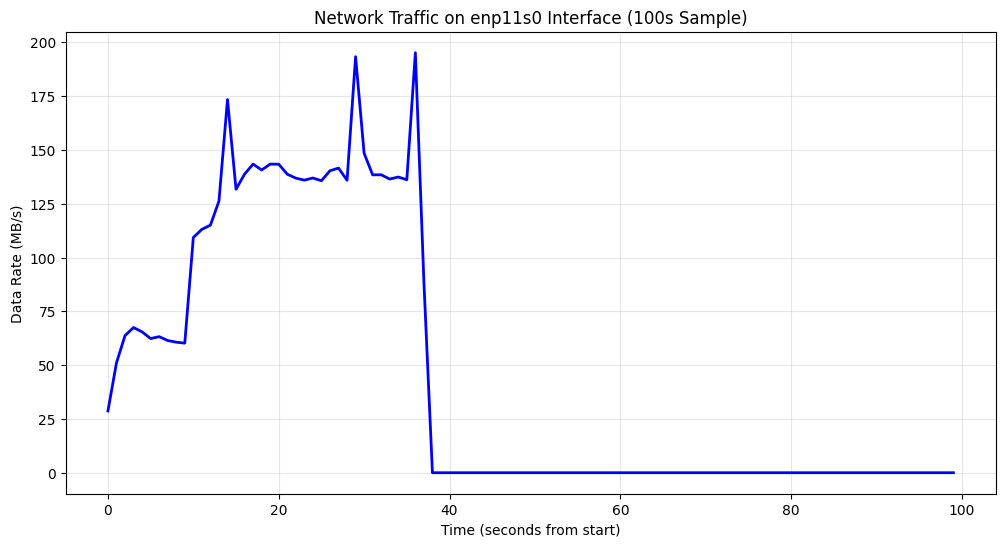

Summary Statistics for enp11s0 (MB/s):
Average: 5.60 MB/s
Maximum: 24.39 MB/s
Minimum: 0.00 MB/s


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Read the CSV file
df = pd.read_csv('data.csv')

# Convert timestamp to datetime for better plotting
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Extract unique timestamps to handle duplicates
df = df.drop_duplicates(subset=['timestamp'])

# Extract data for enp11s0 interface
enp11s0_data = df[['timestamp', 'enp11s0']]

# Replace NaN or empty strings with 0
enp11s0_data['enp11s0'] = enp11s0_data['enp11s0'].replace('', 0).fillna(0).astype(float)

# Take the first 100 seconds of data
# If there are fewer than 100 rows, take all available data
end_idx = min(100, len(enp11s0_data))
enp11s0_100s = enp11s0_data.iloc[:end_idx].copy()

# Calculate seconds from first timestamp for x-axis
enp11s0_100s['seconds'] = (enp11s0_100s['timestamp'] - enp11s0_100s['timestamp'].iloc[0]).dt.total_seconds()

# Create a visualization
plt.figure(figsize=(12, 6))
plt.plot(enp11s0_100s['seconds'], enp11s0_100s['enp11s0'] * 8 / 1000000, 'b-', linewidth=2)
# plt.fill_between(enp11s0_100s['seconds'], enp11s0_100s['enp11s0'] * 8 / 1000000, alpha=0.3)

# Add labels and title
plt.xlabel('Time (seconds from start)')
plt.ylabel('Data Rate (MB/s)')
plt.title('Network Traffic on enp11s0 Interface (100s Sample)')
plt.grid(True, alpha=0.3)

# Add annotations for peak values
peak_idx = enp11s0_100s['enp11s0'].idxmax()
peak_time = enp11s0_100s.loc[peak_idx, 'seconds']
peak_value = enp11s0_100s.loc[peak_idx, 'enp11s0'] / 1000000

# Save the visualization
plt.savefig('enp11s0_traffic.png', dpi=300, bbox_inches='tight')

# Display the plot
plt.show()

# Print summary statistics
print(f"Summary Statistics for enp11s0 (MB/s):")
print(f"Average: {enp11s0_100s['enp11s0'].mean() / 1000000:.2f} MB/s")
print(f"Maximum: {enp11s0_100s['enp11s0'].max() / 1000000:.2f} MB/s")
print(f"Minimum: {enp11s0_100s['enp11s0'].min() / 1000000:.2f} MB/s")

# Export the extracted data to a CSV file
enp11s0_100s[['timestamp', 'enp11s0']].to_csv('enp11s0_100s_data.csv', index=False)

<ipython-input-2-0ecdd3d17025>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  enp11s0_data['enp11s0'] = enp11s0_data['enp11s0'].replace('', 0).fillna(0).astype(float)


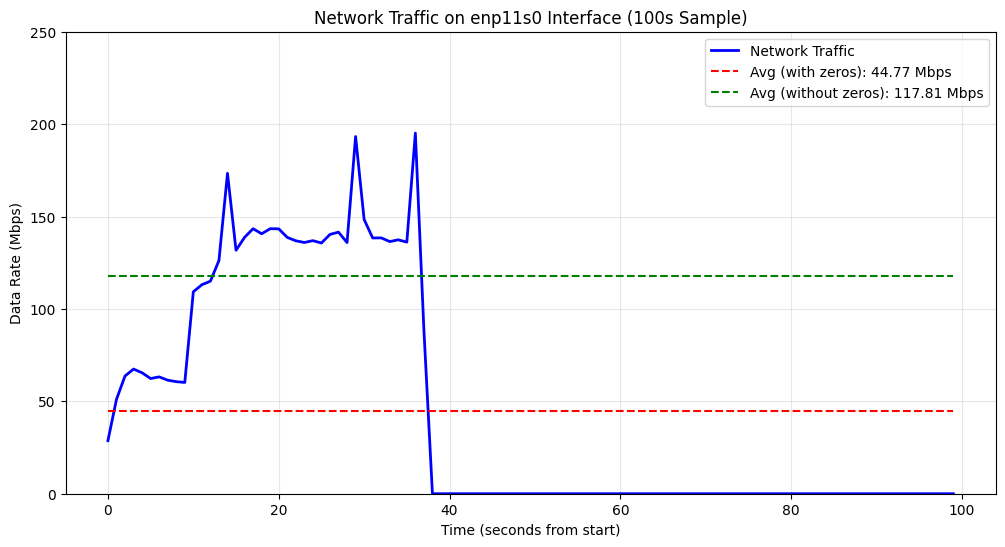

Data and visualization saved successfully!


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Read the data file
df = pd.read_csv('data.csv')

# Convert timestamp to datetime for better plotting
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Remove duplicate timestamps (if any)
df = df.drop_duplicates(subset=['timestamp'])

# Extract data for enp11s0 interface
enp11s0_data = df[['timestamp', 'enp11s0']]

# Replace any empty strings with 0 and convert to float
enp11s0_data['enp11s0'] = enp11s0_data['enp11s0'].replace('', 0).fillna(0).astype(float)

# Take the first 100 seconds of data (or all if less than 100)
end_idx = min(100, len(enp11s0_data))
enp11s0_100s = enp11s0_data.iloc[:end_idx].copy()

# Calculate seconds from first timestamp for x-axis
enp11s0_100s['seconds'] = (enp11s0_100s['timestamp'] - enp11s0_100s['timestamp'].iloc[0]).dt.total_seconds()

# Calculate averages
avg_with_zeros = enp11s0_100s['enp11s0'].mean()
avg_without_zeros = enp11s0_100s.loc[enp11s0_100s['enp11s0'] > 0, 'enp11s0'].mean()

# Create the visualization
plt.figure(figsize=(12, 6))

# Plot the main data
plt.plot(enp11s0_100s['seconds'], enp11s0_100s['enp11s0'] * 8 / 1000000, 'b-', linewidth=2, label='Network Traffic')
# No fill between as per updated code

# Get x-axis range to draw average lines from beginning
x_min = 0
x_max = enp11s0_100s['seconds'].max()

# Plot the averages from x=0
plt.plot([x_min, x_max], [avg_with_zeros * 8 / 1000000, avg_with_zeros * 8 / 1000000],
         'r--', label=f'Avg (with zeros): {avg_with_zeros*8/1000000:.2f} Mbps')
plt.plot([x_min, x_max], [avg_without_zeros * 8 / 1000000, avg_without_zeros * 8 / 1000000],
         'g--', label=f'Avg (without zeros): {avg_without_zeros*8/1000000:.2f} Mbps')

# Add labels and title
plt.xlabel('Time (seconds from start)')
plt.ylabel('Data Rate (Mbps)')
plt.title('Network Traffic on enp11s0 Interface (100s Sample)')
plt.grid(True, alpha=0.3)
plt.legend(loc='upper right')

# Set y-axis to start at 0 with steps of 50
plt.ylim(bottom=0)
plt.yticks(np.arange(0, plt.ylim()[1] + 50, 50))

# Save the visualization
plt.savefig('enp11s0_traffic_with_averages.png', dpi=300, bbox_inches='tight')

# Display the plot
plt.show()

# Export the extracted data to a CSV file
enp11s0_100s[['timestamp', 'seconds', 'enp11s0']].to_csv('enp11s0_100s_data.csv', index=False)

print(f"Data and visualization saved successfully!")